# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [130]:
%%time
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
print("Treino X:", X_train.shape)
print("Test X:", X_test.shape)

Treino X: (7352, 562)
Test X: (2947, 562)


### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [131]:
%%time
# Organizando variáveis para jogar no train_test_split
X = X_train
y = y_train

#Separando dataframe entre treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=42)
print("Nova base de treino: %s linhas" % X_train.shape[0])
print("Base de validação: %s linhas" % X_valid.shape[0])

Nova base de treino: 5514 linhas
Base de validação: 1838 linhas


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [132]:
%%time
# Rodando árvore de decisão com max_depth igual a 4.
clf = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train, y_train)
# Encontrando o percentual de importância das features
most_important_features = clf.feature_importances_
# Transformando o resultado da lista de melhores variáveis em um DataFrame e filtrando as 3 melhores variáveis
most_important_features = (pd.Series(most_important_features, index=X_train.columns)
                           .nlargest(3).reset_index()
                           .rename(columns={'index': 'features', 0:'values'}))

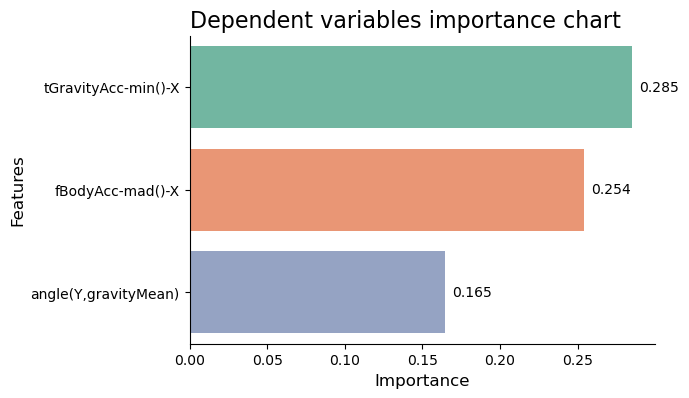

In [145]:
%%time
# Plotando as 3 melhores variáveis
ax = plt.figure(figsize=(6,4))
ax = sns.barplot(most_important_features, x=most_important_features['values'], 
                 y=most_important_features['features'], orient='h', palette="Set2")
ax.bar_label(ax.containers[0], fmt="%.3f",padding=5)
ax.set_title("Dependent variables importance chart", fontsize=16, loc="left")
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel("Features", fontsize=12)
sns.despine()
plt.show()

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

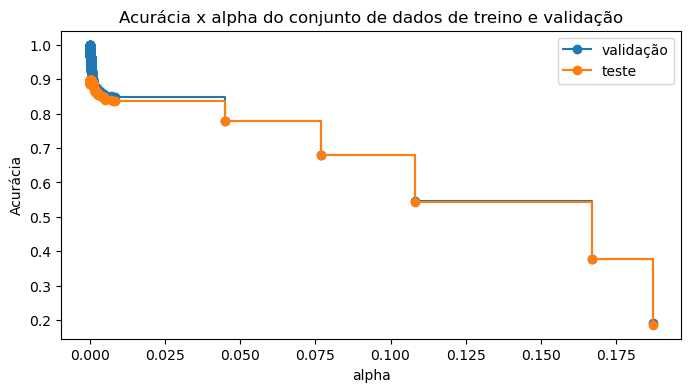

CPU times: total: 6.81 s
Wall time: 6.82 s


In [161]:
%%time
# 3 variáveis que serão usadas na construção da árvore de decisão
cols_included = most_important_features['features'].tolist()
# Rodando método cost_complexity_pruning_path e listando os ccp_alphas
clf_path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train[cols_included], y_train)
ccp_alphas, impurities = clf_path.ccp_alphas, clf_path.impurities

# Listando as possibilidades de ccp_alphas na variável clfs
clfs = []
for ccp_alpha in ccp_alphas:
    clf_ccp = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train[cols_included], y_train)
    clfs.append(clf_ccp)
    
# Usando list comprehesion para listar ccps e plotar gráfico
train_scores = [clf.score(X_train[cols_included], y_train) for clf in clfs]
valid_scores = [clf.score(X_valid[cols_included], y_valid) for clf in clfs]

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [170]:
%%time
# Encontrando o melhor ccp_alpha
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_ccp = clfs[ind_melhor_arvore].ccp_alpha

# Verificando os valores de treino e validação
print(f'Acurácia da melhor árvore na base de validação: {train_scores[ind_melhor_arvore]*100:.2f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

# Printando o melhor ccp
print("Melhor ccp_alpha: ", melhor_ccp)

Acurácia da melhor árvore na base de validação: 95.74
Acurácia da melhor árvore na base de validação: 89.83
Melhor ccp_alpha:  0.000346942959423444


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

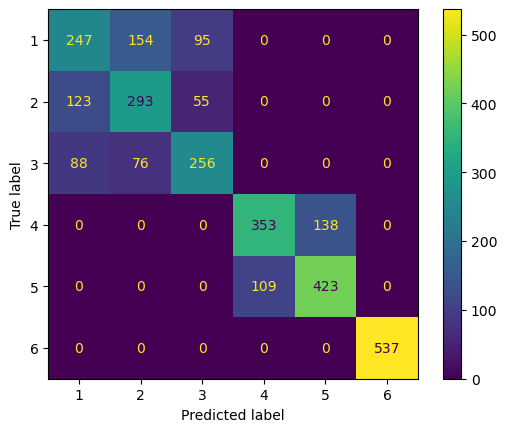

Score final de treino:  0.7156430268069223


In [181]:
%%time
predictions = clfs[ind_melhor_arvore].predict(X_test[cols_included])

cm = confusion_matrix(y_test, predictions, labels=clfs[ind_melhor_arvore].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfs[ind_melhor_arvore].classes_)
disp.plot()
plt.show()

print("Score final de treino: ", clfs[ind_melhor_arvore].score(X_test[cols_included], y_test))

A árvore final teve a acurácia reduzida quando usamos o ccp_alpha da validação para o treino. Tendo em vista essa redução no percentual de acerto, há algumas maneiras de contornar essa situação: (1) incluir as 5 primeiras features com maior percentual de importância no modelo, (2) verificar se bibliotécas como o gridsearch ou randomsearch poderiam auxiliar a encontrar melhores parâmetros para o modelo, (3) utilizar bibliotecas de seleção de features (RFECV) para auxiliar na busca das melhores features. 